<a href="https://colab.research.google.com/github/champ-byte/mesa_learning/blob/main/mesa_sugarscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import dependencies

In [ ]:
import sys
print("Python version")
print(sys.version)


Python version
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
!pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 621.4/621.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.9/252.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 k

In [ ]:
import mesa
import math
import numpy as np
import networkx as nx

# Helper function

In [ ]:
def get_distance(pos_1, pos_2):
  """Get the distance between two point

  Args:
  pos_1: Coordinate tuples for point1.
  pos_2: Coordinate tuples for point2.
  """
  x1, y1 = pos_1
  x2, y2 = pos_2

  dx = abs(x1 - x2)
  dy = abs(y1 - y2)
  return math.sqrt(dx * dx + dy * dy)

def flatten(list_of_lists):
  '''
  helper function for model datacollector for trade price
  collapses the agent prices list into one list
  '''
  return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
  '''
  helper function for model datacollector for trade price
  find the geometric mean from a list of prices
  '''
  return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
  '''
  For agent reports in data collectors
  return list of trade partners and none for other agents
  '''
  if type(agent)==Trader:
    return agent.trade_partners
  else:
    return None

# Resource classes

In [ ]:
class Sugar(mesa.Agent):
  '''
  Sugar:
  - contains an amount of sugar
  -grows one amount of sugar at each turn
  '''
  def __init__(self, model, pos, max_sugar):
    super().__init__(model)
    self.pos = pos
    self.max_sugar = max_sugar
    self.amount= max_sugar

  def step(self):
    '''
    grow one amount of sugar at each turn, until max_sugar is reached
    '''
    self.amount = min([self.max_sugar, self.amount + 1])
    #print(self.unique_id,self.amount,self.max_sugar)

In [ ]:
class Spice(mesa.Agent):
  '''
  Spice:
  - contains an amount of spice
  -grows one amount of spice at each turn
  '''
  def __init__(self, model, pos, max_spice):
    super().__init__(model)
    self.pos = pos
    self.max_spice = max_spice
    self.amount = max_spice

  def step(self):
    '''
    grow one amount of spice at each turn, until max_spice is reached
    '''
    self.amount = min([self.max_spice, self.amount + 1])
    #print(self.unique_id,self.amount,self.max_spice)

# Trader class

In [ ]:
class Trader(mesa.Agent):
  '''
  trader:
  - has a metabolism for sugar and spice
  - harvest and trade sugar and spice to survive and thrive
  '''
  def __init__(self, model, pos, moore=False, sugar_amount=0, spice_amount=0, metabolism_sugar=0, metabolism_spice=0, vision=0):
    super().__init__(model)
    self.pos = pos
    self.moore = moore
    self.sugar = sugar_amount
    self.spice = spice_amount
    self.metabolism_sugar = metabolism_sugar
    self.metabolism_spice = metabolism_spice
    self.vision = vision
    self.prices=[]
    self.trade_partners=[]


  def get_sugar(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    used in self.eat()
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if isinstance(agent, Sugar):
        return agent
    return None

  def get_sugar_amount(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''
    sugar_patch=self.get_sugar(pos)
    if sugar_patch is None:
      return 0
    return sugar_patch.amount

  def get_spice(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if type(agent) is Spice:
        return agent
    return None

  def get_spice_amount(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''
    spice_patch=self.get_spice(pos)
    if spice_patch is None:
      return 0
    return spice_patch.amount

  def is_occupied_by_other(self, pos):
    '''
    helper function to check if a position is occupied by another agent
    '''
    if pos==self.pos:
      return False #agent's position is considered unoccupied as it can stay there
    #get contents of each cell in the neighborhood
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if isinstance(agent, Trader):
        return True
    return False

  def get_trader(self, pos):
    '''
    helper function to get trader agent in a position
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if isinstance(agent, Trader):
        return agent
    return None

  def calculate_welfare(self, sugar_amount, spice_amount):
    '''
    helper function part2 of move function
    self.trade()
    '''
    #calculate total metabolism
    total_metabolism = self.metabolism_sugar + self.metabolism_spice
    #cobb douglas function
    return (sugar_amount ** (self.metabolism_sugar / total_metabolism)) * (spice_amount) ** (self.metabolism_spice / total_metabolism)

  def calculate_MRS(self,sugar,spice):
    '''
    helper function to self.trade()
    Determine what trader agent needs and can give up
    '''
    return (spice/self.metabolism_spice)/(sugar/self.metabolism_sugar)

  def calculate_sell_spice_amount(self,price):
    '''
    helper function to maybe_sell_spice()
    '''
    if price >=1:
      sugar=1
      spice=int(price)
    else:
      sugar=int(1/price)
      spice=1
    return sugar,spice

  def sell_spice(self, other, sugar, spice):
    """
    used in self.maybe_sell_spice()

    exchanges sugar and spice between traders
    """

    self.sugar += sugar
    other.sugar -= sugar
    self.spice -= spice
    other.spice += spice

  def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
    '''
    helper function to self.trade()
    '''
    sugar_exchanged,spice_exchanged=self.calculate_sell_spice_amount(price)

    # assess new sugar and spice amount - what if change did occur
    # here it is assumed that mrs >1 since spice is subtracted
    self_sugar=self.sugar+sugar_exchanged
    other_sugar=other.sugar-sugar_exchanged
    self_spice=self.spice - spice_exchanged
    other_spice=other.spice+spice_exchanged

    # double check to ensure agents have resources

    if ((self_sugar <= 0) or (other_sugar <= 0) or (self_spice <= 0) or (other_spice <= 0)):
      return False

    # trade criteria #1 - are both agents better off?
    both_agents_better_off = ( welfare_self < self.calculate_welfare(self_sugar, self_spice)) and (welfare_other < other.calculate_welfare(other_sugar, other_spice))

    # trade criteria #2 is their mrs crossing with potential trade
    mrs_not_crossing = self.calculate_MRS( self_sugar, self_spice) > other.calculate_MRS(other_sugar, other_spice)

    if not (both_agents_better_off and mrs_not_crossing):
      return False

    # criteria met, execute trade
    self.sell_spice(other, sugar_exchanged, spice_exchanged)

    return True

  def trade(self, other):
    '''
    helper function for self.trade_with_neighbors()
    other is a trader agent object
    function for trader agent to trade with other trader agents
    '''
    #sanity check to verify code as expected
    assert self.sugar>0
    assert self.spice>0
    assert other.sugar>0
    assert other.spice>0

    # calculate marginal rate of substituition in Growing Artificial societies page 103
    mrs_self = self.calculate_MRS(self.sugar, self.spice)
    mrs_other = other.calculate_MRS(other.sugar, other.spice)

    # calculate welfares
    welfare_self=self.calculate_welfare(self.sugar,self.spice)
    welfare_other=other.calculate_welfare(other.sugar,other.spice)

    #print(mrs_self,mrs_other,welfare_self,welfare_other)

    if math.isclose(mrs_self,mrs_other):
      return

    price=math.sqrt(mrs_self*mrs_other)
    #print(price)

    if mrs_self>mrs_other:
      # self is a sugar buyer and spice seller
      sold=self.maybe_sell_spice(other,price,welfare_self,welfare_other)
      #print(self.unique_id,other.unique_id,sold)
      # no trade - criteria not met
      if not sold:
        return
    else:
      # self is a spice buyer , sugar seller
      sold=other.maybe_sell_spice(self,price,welfare_other,welfare_self)
      #print(self.unique_id,other.unique_id,sold)
      # no trade - criteria not met
      if not sold:
        return

    # Capture data
    self.prices.append(price)
    self.trade_partners.append(other.unique_id)

    # continue trading
    self.trade(other)


##########################################################
#                                                        #
#              MAIN TRADE FUNCTIONS                      #
#                                                        #
##########################################################

  def move(self):
    '''
    function for trader agent to identify optimal move for each step in 4 part
    1. identify all posiible moves
    2. determine which move maximizes welfare
    3. find closest best option
    4. move
    '''
    #1. identify all possible moves
    neighbors = [i for i in self.model.grid.get_neighborhood(
        self.pos, self.moore, True, self.vision) if not self.is_occupied_by_other(i)]

    #print(self.pos,neighbors)

    #2. determine which move maximizes welfare
    welfares=[
        self.calculate_welfare(
            self.sugar+self.get_sugar_amount(pos),
            self.spice+self.get_spice_amount(pos))
        for pos in neighbors
    ]
    # 3. find closest best option
    max_welfares=max(welfares)
    candidate_indices=[pos for pos, welfare in zip(neighbors,welfares) if math.isclose(welfare,max_welfares)]
    #print(self.pos,candidate_indices)
    min_distance=min(get_distance(self.pos,pos) for pos in candidate_indices)
    # print(self.pos,min_distance)
    final_indices=[pos for pos in candidate_indices if math.isclose(get_distance(self.pos,pos),min_distance)]
    self.random.shuffle(final_indices)
    #print(self.pos,final_indices)

    #move
    self.model.grid.move_agent(self,final_indices[0])

  def eat(self):
    '''
    function for trader agent to eat sugar and spice
    '''
    #get sugar
    sugar_patch=self.get_sugar(self.pos)
    if sugar_patch:
      self.sugar+=sugar_patch.amount
      sugar_patch.amount=0
    self.sugar-=self.metabolism_sugar
    #get spice
    spice_patch=self.get_spice(self.pos)
    if spice_patch:
      self.spice+=spice_patch.amount
      spice_patch.amount=0
    self.spice-=self.metabolism_spice

  def maybe_die(self):
    '''
    function to remove traders who have consumed all resources
    '''
    if (self.sugar <= 0) or (self.spice <= 0): # i.e if is_starved
      self.model.grid.remove_agent(self)
      self.remove()
      #print(self.unique_id,len(self.model.agents_by_type[Trader]))

  def trade_with_neighbors(self):
    '''
    function for trader agent to decide who to trade with
    1.identify neighbors who can trdae
    2. trade
    3. collect data for analysis
    '''
    neighbor_agents=[self.get_trader(pos) for pos in self.model.grid.get_neighborhood(self.pos,self.moore,False,self.vision) if self.is_occupied_by_other(pos)]
    #print(len(neighbor_agents))

    if len(neighbor_agents)==0:
    #  trade returns price and trade network (who agent traded with)
      return [],[]


    #iterate through traders in neighbouring cells and trade
    for a in neighbor_agents:
      if a:
        self.trade(a)

    return


# Model class

In [ ]:

import matplotlib.pyplot as plt


In [ ]:
import mesa.space

In [ ]:
class SugarscapeG1mt(mesa.Model):
  def __init__(self, width=50, height=50, initial_population=200,endowment_min=25,endowment_max=50,metabolism_min=1, metabolism_max=5,vision_min=1, vision_max=5):
      super().__init__()
      self.width = width
      self.height = height
      self.initial_population = initial_population
      self.endowment_min = endowment_min
      self.endowment_max = endowment_max
      self.metabolism_min = metabolism_min
      self.metabolism_max = metabolism_max
      self.vision_min = vision_min
      self.vision_max = vision_max

      self.running = True

      # initiate mesa grid
      self.grid = mesa.space.MultiGrid(self. width, self.height, torus=False)

      #initiate datacollector
      self.datacollector = mesa.DataCollector(

          model_reporters={"Trader": lambda m: len(m.agents_by_type[Trader]),
           "Trade Volume": lambda m: sum(len(a.trade_partners) for a in m.agents_by_type[Trader]),
           "Price": lambda m:geometric_mean(flatten([a.prices for a in m.agents_by_type[Trader]]))},
          agent_reporters={"Trade Network": lambda a : get_trade(a)}
          )

      sugar_distribution = np.genfromtxt("sugar-map.txt")
      spice_distribution = np.flip(sugar_distribution, axis=1)

      for cell_content, (x, y) in self.grid.coord_iter():
          max_sugar = sugar_distribution[x, y]
          if max_sugar > 0:
              sugar = Sugar(self, (x, y), max_sugar)  # No unique_id needed
              self.grid.place_agent(sugar, (x, y))

          max_spice = spice_distribution[x, y]
          if max_spice > 0:
              spice = Spice(self, (x, y), max_spice)  # No unique_id needed
              self.grid.place_agent(spice, (x, y))
      for i in range(self.initial_population):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        sugar_amount = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
        spice_amount = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
        metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
        metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
        vision = int(self.random.uniform(self.vision_min, self.vision_max))
        trader = Trader(self, (x, y), moore=False, sugar_amount=sugar_amount, spice_amount=spice_amount, metabolism_sugar=metabolism_sugar, metabolism_spice=metabolism_spice, vision=vision)
        self.grid.place_agent(trader, (x, y))
      # add the sugar step function
  def step(self):

    # Step agents by type in a specific order
    for agent_class in [Sugar, Spice]:
        self.agents_by_type[agent_class].shuffle_do("step")

    trader_shuffle = self.agents_by_type[Trader].shuffle()
    #step trader agents
    for agent in trader_shuffle:
        agent.prices=[]
        agent.trade_partners=[]
        agent.move();
        agent.eat();
        agent.maybe_die();
    trader_shuffle = self.agents_by_type[Trader].shuffle()

    for agent in trader_shuffle:
        agent.trade_with_neighbors()
        #print(agent.prices,agent.trade_partners)

    #collect model level data
    self.datacollector.collect(self)

  def run_model(self,step_count=1000):
     for i in range(step_count):
        self.step()



## Key Changes in Mesa 3.0

Looking at your `step()` method code and the migration guide, here are the significant changes:

### **From Scheduler-Based to AgentSet-Based**

**Old approach** (your code):
```python
def step(self):
    for sugar in self.schedule. agents_by_type[Sugar]. values():
        sugar.step()
    
    self.schedule.steps += 1
    print(self.schedule.steps, self.schedule.time)
```

**New approach** (Mesa 3.0+):
```python
def step(self):
    self.agents_by_type[Sugar].shuffle_do("step")
    # self.steps is now automatically incremented!
    print(self.steps)  # No more manual tracking needed
```

### **Main Changes:**

1. **Scheduler Removal**: The entire `scheduler` module is deprecated and will be removed in Mesa 3.1.  Replace it with AgentSet functionality.

2. **Automatic Step Counter**:
   - Old: `self.schedule.steps += 1` (manual increment)
   - New: `self.steps` is automatically incremented by the framework

3. **Accessing Agents by Type**:
   - Old: `self.schedule.agents_by_type[AgentType]`
   - New: `self.agents_by_type[AgentType]`

4. **Activating Agents**:
   - Old: `self.schedule.step_type(AgentType)`
   - New: `self.agents_by_type[AgentType].shuffle_do("step")`

5. **Time Tracking**: `self.schedule.time` is removed.  You now rely on `self.steps` and can define your own time variable if needed.

### **For RandomActivationByType Schedulers specifically:**

```python
# Old
self.schedule = RandomActivationByType(self)
self.schedule.step()

# New
for agent_class in self.agent_types:
    self.agents_by_type[agent_class].shuffle_do("step")
```

The migration emphasizes **explicit activation patterns** - you can now clearly see exactly what gets activated in what order, making your model more transparent and flexible.

# Sugarscape model

In [ ]:
import warnings


In [ ]:
warnings.filterwarnings('ignore')
model= SugarscapeG1mt()

In [ ]:
model.run_model()

# analyze data(model level)

In [ ]:
results = model.datacollector.get_model_vars_dataframe()
# results = results.dropna(subset=['Price'])
results

,Trader,Trade Volume,Price
0,200,746,1.026367
1,200,104,1.124703
2,200,142,0.832278
3,200,85,1.095388
4,200,98,1.236813
...,...,...,...
995,54,4,0.833538
996,54,5,0.934110
997,54,5,0.933318
998,54,5,1.000517


<Axes: >

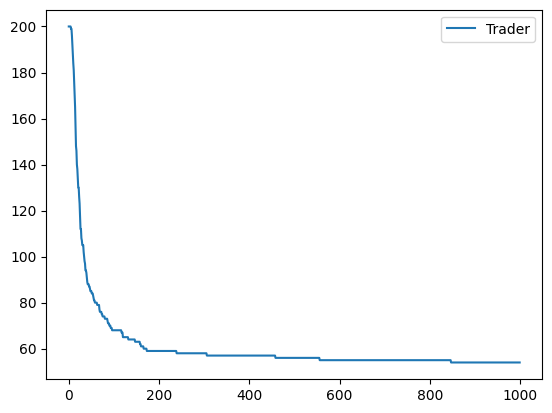

In [ ]:
# plot number of agents per time step
results.plot(y="Trader",use_index=True)

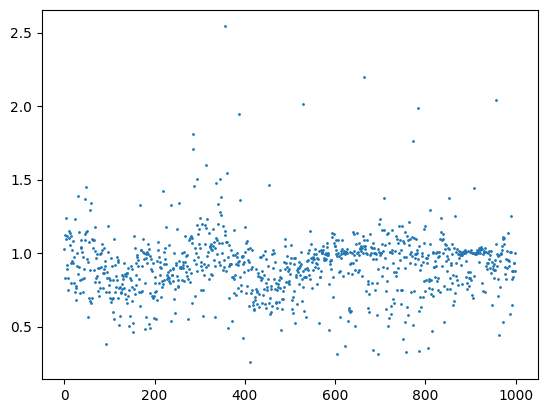

In [ ]:
#plot trade prices
y=list(results.Price)
x=list(range(len(y)))
plt.scatter(x,y,s=1)

<BarContainer object of 1000 artists>

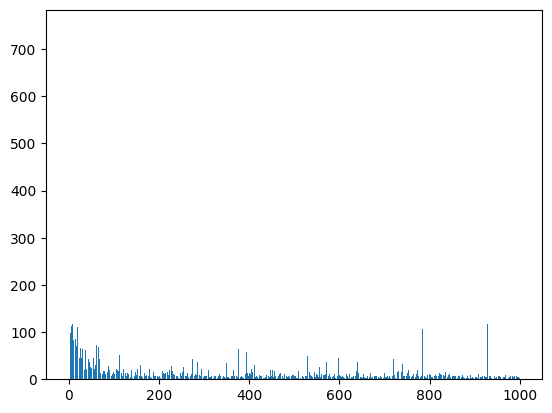

In [ ]:
#plot trade volume
plt.bar(results.index, results['Trade Volume'])

# Agent level data

In [ ]:
# retrieve agent level results
agent_results=model.datacollector.get_agent_vars_dataframe()
# filter out Nones from non-trader agents
agent_results=agent_results[agent_results['Trade Network'].notnull()]
agent_results

Trade Network
Step AgentID                                                   
1    4139                                                    []
     4140                                                    []
     4141                                                    []
     4142     [4256, 4256, 4256, 4256, 4170, 4170, 4170, 417...
     4143                                                    []
...                                                         ...
1000 4307                                                    []
     4309                                                    []
     4318                                                    []
     4319                                                    []
     4326                                                    []

[61315 rows x 1 columns]

In [ ]:
#  create graph object
G = nx.Graph()

# add agent keys to make initial node set
G.add_nodes_from([agent.unique_id for agent in model.agents_by_type[Trader]])

# create edge list
for idx, row in agent_results.iterrows():
  if len(row["Trade Network"]) > 0:
    for agent in row["Trade Network"]:
      G.add_edge(idx[1], agent)

In [ ]:

print("Connectivity: ", nx.node_connectivity(G), "Clustering: ",
      nx.average_clustering(G), "Efficiency: ", nx.global_efficiency(G))

try:
  print("Diameter: ", nx.diameter(G))
except:
  print("Some traders not connected")

Connectivity:  0 Clustering:  0.45390622559890437 Efficiency:  0.4329879101901083
Some traders not connected


(array([68., 40., 17., 10.,  5., 10., 10., 13., 13.,  7.]),
 array([ 1. ,  6.6, 12.2, 17.8, 23.4, 29. , 34.6, 40.2, 45.8, 51.4, 57. ]),
 <BarContainer object of 10 artists>)

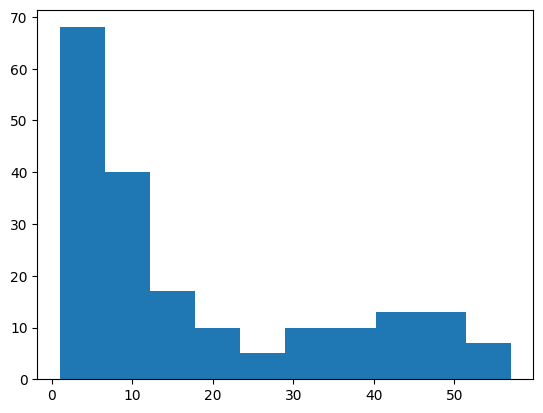

In [ ]:

degree = [d for n,d in G.degree()]
plt.hist(degree)

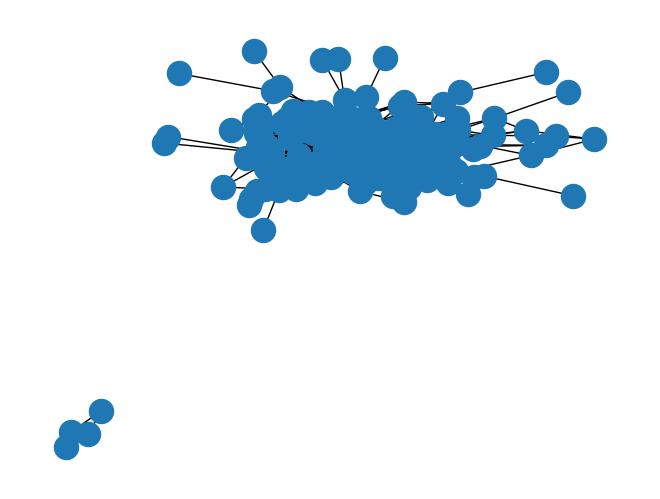

In [ ]:
nx.draw(G)

# Batch run and analysis

In [ ]:
params = { "width": 50, "height": 50,
          "vision_min": range(1,3),
          "metabolism_max": [3,5]}

results_batch = mesa.batch_run(
    SugarscapeG1mt,
    parameters = params,
    iterations = 1,
    max_steps = 100, # Reduced number of steps for each model run
    number_processes = 1,
    data_collection_period = 10, # Collect data every 10 steps instead of every step
    display_progress = True
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results_batch)
results_df

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,479,0.991958,NaN,NaN
1,0,0,10,50,50,1,3,200,80,1.171862,1.0,None
2,0,0,10,50,50,1,3,200,80,1.171862,2.0,None
3,0,0,10,50,50,1,3,200,80,1.171862,3.0,None
4,0,0,10,50,50,1,3,200,80,1.171862,4.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
170920,3,0,100,50,50,2,5,80,9,1.100127,4327.0,[]
170921,3,0,100,50,50,2,5,80,9,1.100127,4331.0,[]
170922,3,0,100,50,50,2,5,80,9,1.100127,4335.0,[]
170923,3,0,100,50,50,2,5,80,9,1.100127,4337.0,[]


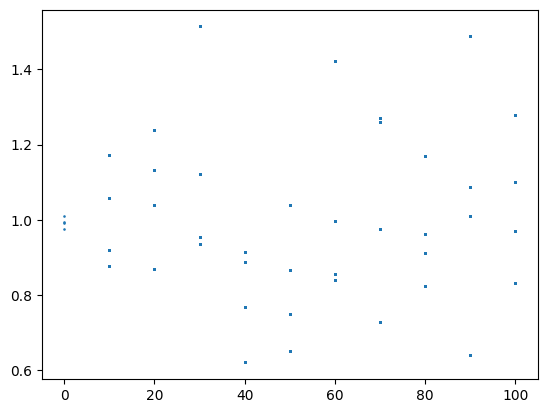

In [ ]:
plt.scatter(results_df["Step"], results_df["Price"], s=0.75)

In [ ]:
results_explore = results_df[results_df["metabolism_max"]== 3]
results_explore

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,479,0.991958,NaN,NaN
1,0,0,10,50,50,1,3,200,80,1.171862,1.0,None
2,0,0,10,50,50,1,3,200,80,1.171862,2.0,None
3,0,0,10,50,50,1,3,200,80,1.171862,3.0,None
4,0,0,10,50,50,1,3,200,80,1.171862,4.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
128461,2,0,100,50,50,2,3,163,107,0.971223,4332.0,[]
128462,2,0,100,50,50,2,3,163,107,0.971223,4334.0,[4324]
128463,2,0,100,50,50,2,3,163,107,0.971223,4335.0,[]
128464,2,0,100,50,50,2,3,163,107,0.971223,4337.0,[]


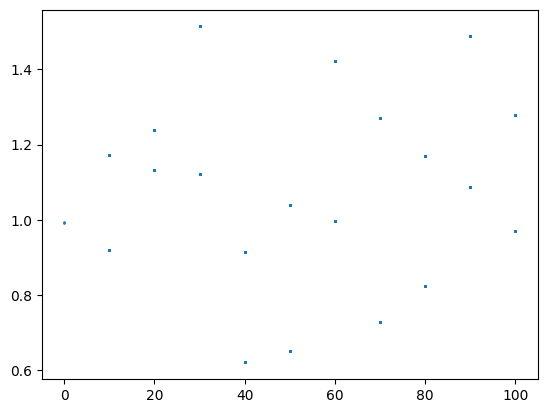

In [ ]:
plt.scatter(results_explore["Step"], results_explore["Price"], s=0.75)

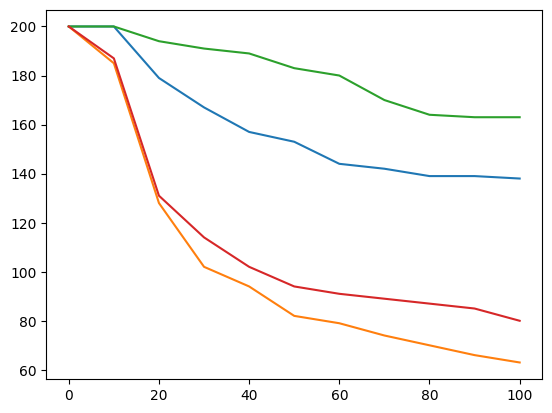

In [ ]:

for i in range(4):
  results_explore = results_df[results_df["RunId"] ==i]
  plt.plot(results_explore["Step"], results_explore["Trader"])

In [ ]:

#Agent results
G = nx.Graph()

trade = results_df.dropna(subset=["Trade Network"])
# add agent keys to make initial node set
G.add_nodes_from(list(trade["AgentID"].unique()))

# create edge list
for idx, row in trade.iterrows():
    if len(row["Trade Network"]) > 0:
        for agent in row["Trade Network"]:
            G.add_edge(row["AgentID"], agent)

In [ ]:

#Get some statistics

print(f"Node Connectivity {nx.node_connectivity(G)}")
print(f"Average Clustering {nx.average_clustering(G)}")
print(f"Global Efficiency {nx.global_efficiency(G)}")

Node Connectivity 1
Average Clustering 0.07241830112611847
Global Efficiency 0.4197294807371373


(array([ 9., 25., 39., 38., 34., 18., 12., 13.,  6.,  6.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

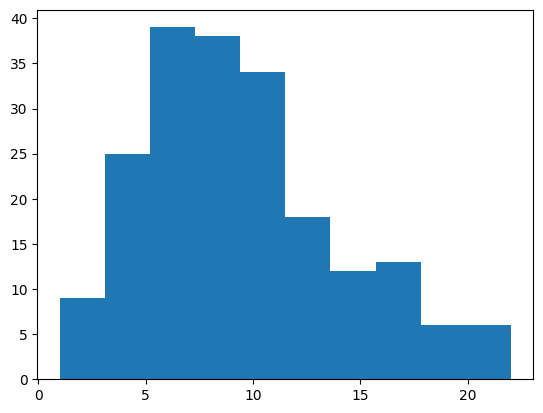

In [ ]:

#Plot a histogram of number of links

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence)

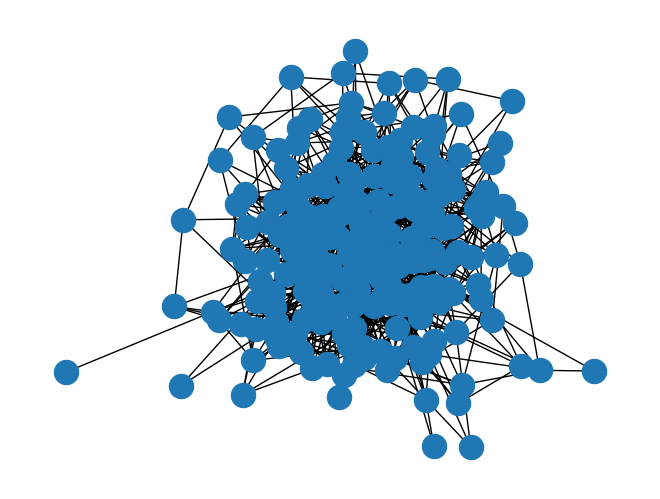

In [ ]:

# Plot network
nx.draw(G)
